In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
import numpy as np #vectors and matrices
import pandas as pd #tables and data manipulations
import matplotlib.pyplot as plt #plots
import seaborn as sns #more plots
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

In [31]:
%matplotlib inline

In [32]:
df = pd.read_csv('all_stocks_5yr.csv', usecols = ['date', 'high', 'Name'])

In [33]:
df2 = pd.read_csv('S&P Retail Select Industry Historical Data.csv', usecols = ['Date', 'High'])

In [34]:
cond = {'Name' : 'AMZN'}

In [35]:
amzn_data = df.loc[df.Name==cond['Name'], ['date', 'high', 'Name']]

In [36]:
amzn_data_t = df.loc[df.Name==cond['Name'], ['high']]

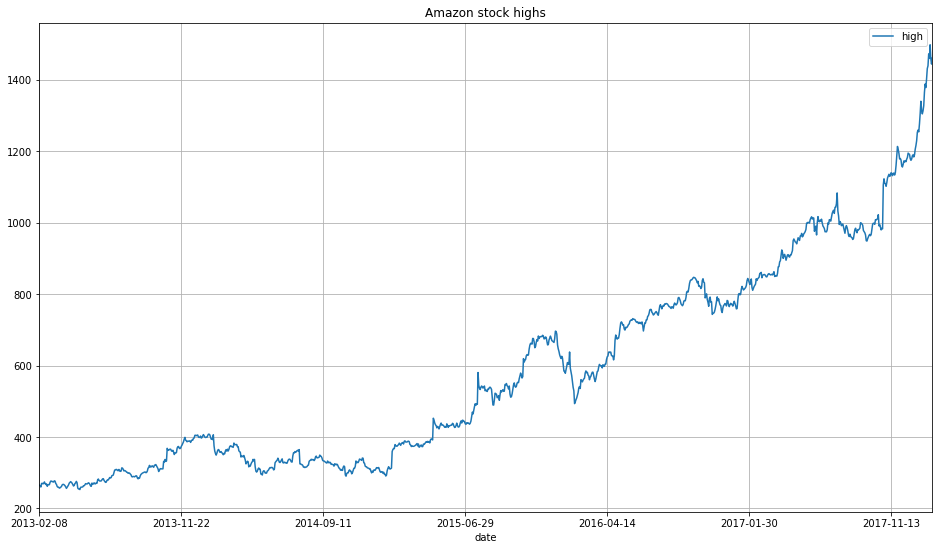

In [37]:
amzn_data.plot(x='date', y='high', figsize=(16,9), grid=True, title="Amazon stock highs")

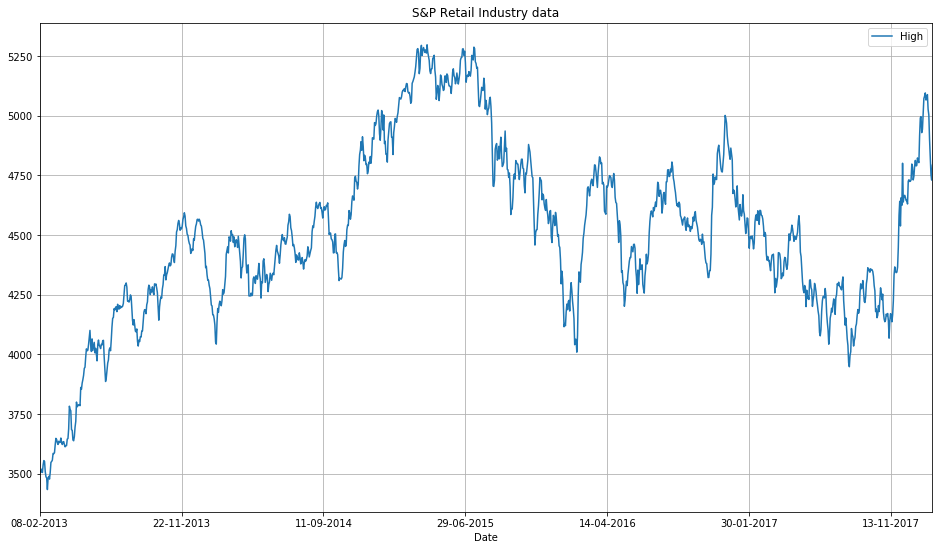

In [38]:
df2.plot(x='Date', y='High', figsize=(16,9), grid=True, title="S&P Retail Industry data")

In [39]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(16, 9))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #Plot confidence intervals for smooth values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation=np.std(series[window:]-rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")

        #Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.high)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)


In [ ]:
plotMovingAverage(amzn_data_t, 6, plot_intervals=True, plot_anomalies=True )

In [41]:
amzn_data_t.corrwith(df2)

High   NaN
high   NaN
dtype: float64